# Import Library

In [1]:
import ccxt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import requests

# Initialize Config

In [2]:
symbol = 'BTC_THB'
timeframe = 1

# Data Processing

## Fetch Data

In [3]:
url = "https://api.bitkub.com/tradingview/history?symbol={symbol}&resolution={timeframe}&from=1700488800&to=1702285200".format(symbol=symbol, timeframe=timeframe)
response = requests.get(url)
data = response.json()
del data["s"]

## Convert to Dataframe

In [4]:
df = pd.DataFrame(data).rename(columns={
    "c": "close",
    "h": "high",
    "l": "low",
    "o": "open",
    "t": "timestamp",
    "v": "volume"
})
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') 
df.set_index('timestamp', inplace=True)

# Stationarity Check

In [12]:
def Stationarity_check(data):
    result = adfuller(data, autolag='AIC')
    print('\nAugmented Dickey-Fuller Test Results:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')
    print('\nThe data is Stationary.') if result[1] <= 0.05 else print('\nThe data is not Stationary.')

In [13]:
Stationarity_check(df["close"])


Augmented Dickey-Fuller Test Results:
ADF Statistic: -0.5646878007482357
p-value: 0.8787631882814084
Critical Values: {'1%': -3.4306101212223936, '5%': -2.8616549657333072, '10%': -2.566831192893382}

The data is not Stationary.


# Alternative Ways

## Differencing

difference of the series by subtracting the previous value from the current one.

In [20]:
df['close_diff'] = df['close'].diff()

In [17]:
Stationarity_check(df["close_diff"])

MissingDataError: exog contains inf or nans

## Log Transformation

Apply a log transformation to stabilize variance.

In [9]:
df['close_log'] = df['close'].apply(lambda x: np.log(x))

In [10]:
Stationarity_check(df["close_diff"])


Augmented Dickey-Fuller Test Results:
ADF Statistic: -25.699336537090865
p-value: 0.0
Critical Values: {'1%': -3.4306101212223936, '5%': -2.8616549657333072, '10%': -2.566831192893382}

The data is Stationary.


## Moving Average

In [11]:
average_bar = 24
df['close_ma'] = df['close'].rolling(window=average_bar).mean()

In [12]:
Stationarity_check(df["close_ma"])


Augmented Dickey-Fuller Test Results:
ADF Statistic: -0.41441021112555526
p-value: 0.9076648432626147
Critical Values: {'1%': -3.4306104735015874, '5%': -2.8616551214232526, '10%': -2.5668312757637683}

The data is not Stationary.


# Plot Setup

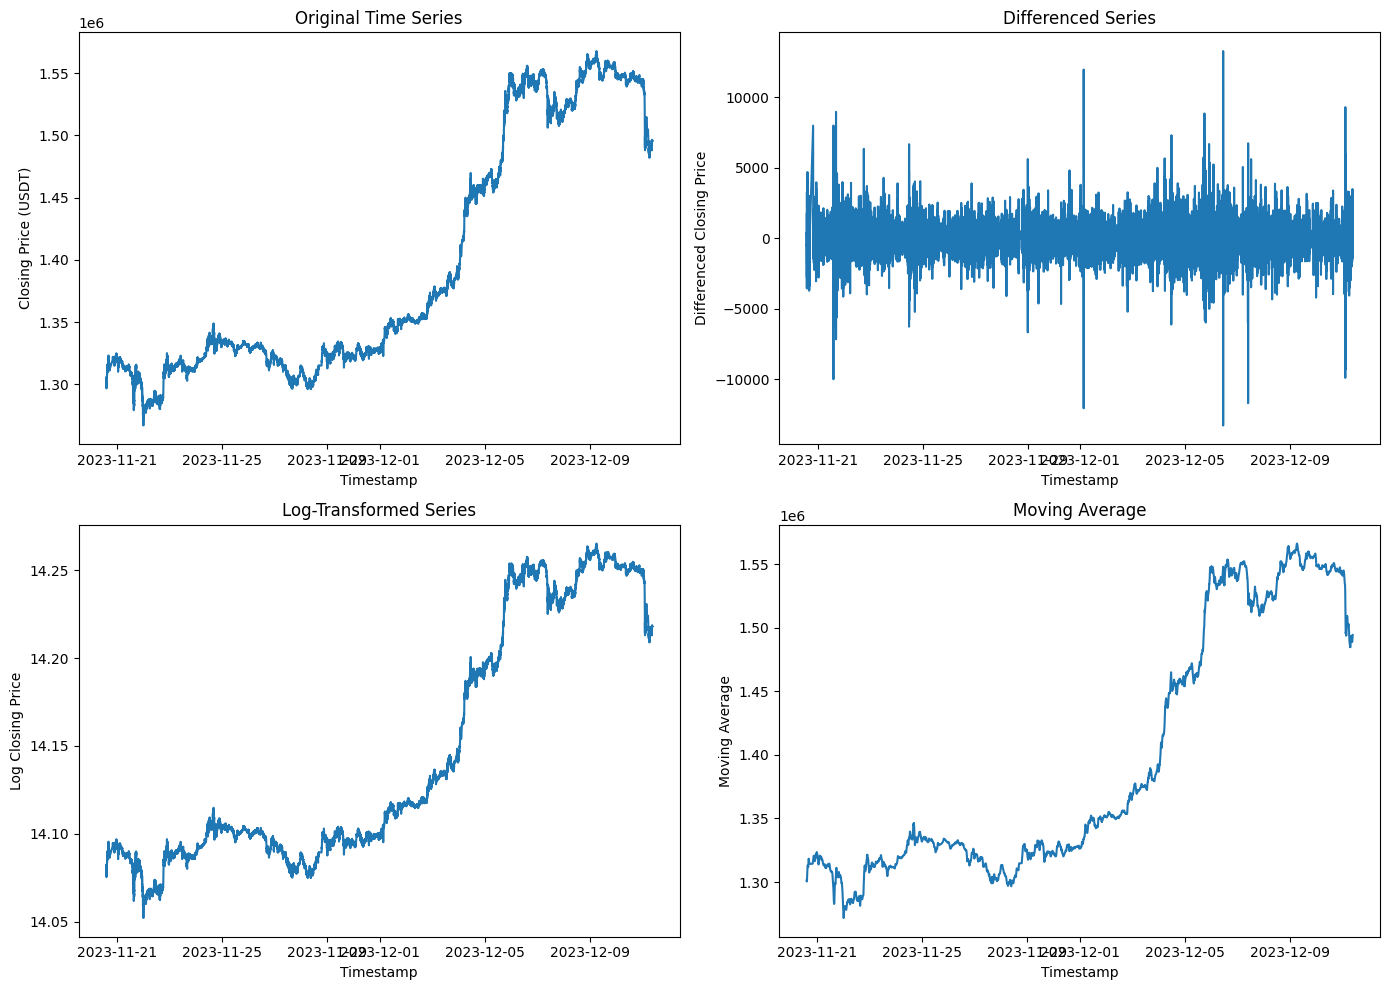

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Original Time Series
axes[0, 0].plot(df['close'])
axes[0, 0].set_title('Original Time Series')
axes[0, 0].set_xlabel('Timestamp')
axes[0, 0].set_ylabel('Closing Price (USDT)')

# Differenced Series
axes[0, 1].plot(df['close_diff'])
axes[0, 1].set_title('Differenced Series')
axes[0, 1].set_xlabel('Timestamp')
axes[0, 1].set_ylabel('Differenced Closing Price')

# Log-Transformed Series
axes[1, 0].plot(df['close_log'])
axes[1, 0].set_title('Log-Transformed Series')
axes[1, 0].set_xlabel('Timestamp')
axes[1, 0].set_ylabel('Log Closing Price')

# Moving Average
axes[1, 1].plot(df['close_ma'])
axes[1, 1].set_title('Moving Average')
axes[1, 1].set_xlabel('Timestamp')
axes[1, 1].set_ylabel('Moving Average')

plt.tight_layout()
plt.show()